# Chapter 4
* Author: Kenji Oman ([github profile](https://github.com/kenjioman))
* Date: 28 February 2019

The B-spline work in the chapter is new to this edition.  To ensure I understand how to do this, I will re-create this work here.

In [1]:
# Necessary imports
import numpy as np
import pandas as pd
import pymc3 as pm
import patsy

%matplotlib inline
import matplotlib.pyplot as plt

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## R Code 4.72
(skip the histograms, since I didn't have any hand in creating the data myself)

In [2]:
# First, import the cherry blossoms data
df = pd.read_csv('../Data/cherry_blossoms.csv', sep=';', header=0)
df.head()

,year,doy,temp,temp_upper,temp_lower
0,801,NaN,NaN,NaN,NaN
1,802,NaN,NaN,NaN,NaN
2,803,NaN,NaN,NaN,NaN
3,804,NaN,NaN,NaN,NaN
4,805,NaN,NaN,NaN,NaN


In [3]:
# Look at the data real quick
df.describe(percentiles=[0.055, 0.945])

,year,doy,temp,temp_upper,temp_lower
count,1215.000000,827.000000,1124.000000,1124.000000,1124.000000
mean,1408.000000,104.540508,6.141886,7.185151,5.098941
std,350.884596,6.407036,0.663648,0.992921,0.850350
min,801.000000,86.000000,4.670000,5.450000,0.750000
5.5%,867.770000,94.430000,5.150000,5.897650,3.787650
50%,1408.000000,105.000000,6.100000,7.040000,5.145000
94.5%,1948.230000,115.000000,7.294700,8.902350,6.370000
max,2015.000000,124.000000,8.300000,12.100000,7.740000


## R Code 4.73

In [4]:
# First, drop any rows where temp was nan
df2 = df[~df.temp.isna()]
# Define the knot positions
num_knots = 15
knot_list = np.quantile(df2.year, q=np.linspace(0,1, num=num_knots))
knot_list

array([ 839.        ,  937.21428571, 1017.42857143, 1097.64285714,
       1177.85714286, 1258.07142857, 1338.28571429, 1418.5       ,
       1498.71428571, 1578.92857143, 1659.14285714, 1739.35714286,
       1819.57142857, 1899.78571429, 1980.        ])

## R Code 4.74

In [5]:
# Construct our B matrix (example from
# https://patsy.readthedocs.io/en/latest/spline-regression.html#general-b-splines)
B = patsy.dmatrix("bs(year, knots=knots, degree=3, include_intercept=True)",
                   data={'year': df2.year.values,
                         'knots': knot_list[1:-1]})
B.shape

(1124, 18)

Although we have one more column than in the book, we have an intercept column (all values are 1), where in the plotting, if we want the same number of functions to be plotted as the book, we need to have an extra basis function (and don't plot the intercept column).

## R Code 4.75

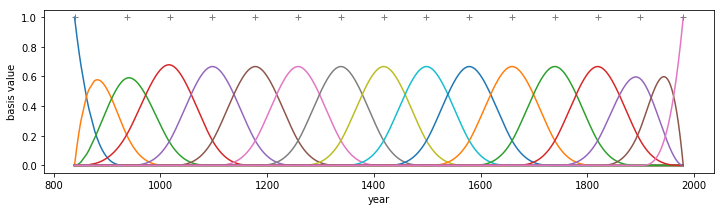

In [6]:
# Plot each of the lines
plt.figure(figsize=(12,3))
for i in range(1, B.shape[1]):
    plt.plot(df2.year, B[:, i])
plt.plot(knot_list, [1 for x in knot_list], '+')
plt.xlabel('year')
plt.ylabel('basis value')
plt.show()

## R Code 4.76
Note, since PyMC3 doesn't come with the quadratic approximation built in, we will just use a sampling method instead.

In [7]:
# Set the seed for reproducibility
np.random.seed(123)
with pm.Model() as m4_7:
    a = pm.Normal('a', 6, 10)
    ws = [pm.Normal(f'w{i}', mu=0, sd=1) for i in range(B.shape[1])]
    # Although I think this commented out solution is correct, it is very slow
    #ws = pm.Normal('w', mu=0, sd=1, shape=(B.shape[1], 1))
    #mu = a + pm.math.dot(np.asarray(B), ws)
    mu = pm.Deterministic('mu', a + pm.math.dot(np.asarray(B), pm.math.stack(ws).T))
    sigma = pm.Exponential('sigma', 1)
    T = pm.Normal('T', mu, sigma, observed=df2.temp)
    trace = pm.sample(draws=1000, tune=1000, discard_tuned_samples=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, w17, w16, w15, w14, w13, w12, w11, w10, w9, w8, w7, w6, w5, w4, w3, w2, w1, w0, a]
100%|██████████| 2000/2000 [05:22<00:00,  7.07it/s]
The number of effective samples is smaller than 25% for some parameters.


## R Code 4.77

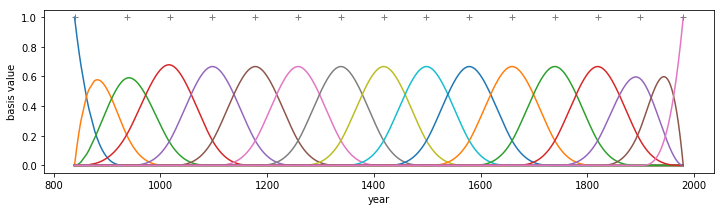

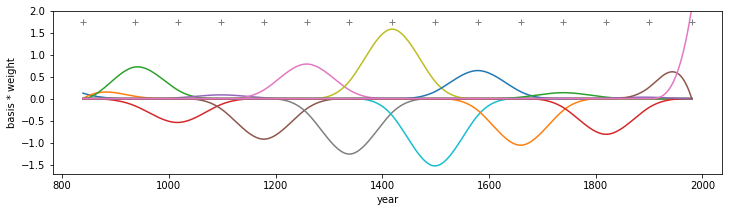

In [8]:
# Now, convert to df
post = pm.trace_to_dataframe(trace)

# And now, calculate the average value of the weight parameter across our runs
w = post.loc[:, [f'w{i}' for i in range(B.shape[1])]].mean(axis=0).values


# Now, plot the original basis functions again
plt.figure(figsize=(12,3))
for i in range(1, B.shape[1]):
    plt.plot(df2.year, B[:, i])
plt.plot(knot_list, [1 for x in knot_list], '+')
plt.xlabel('year')
plt.ylabel('basis value')
plt.show()

# And, plot the weights times our basis functions
plt.figure(figsize=(12,3))
for i in range(1, B.shape[1]):
    plt.plot(df2.year, B[:, i] * w[i])
plt.ylim(top=2)
plt.plot(knot_list, [1.75 for x in knot_list], '+')
plt.ylabel('basis * weight')
plt.xlabel('year')
plt.show()

## R Code 4.78

In [9]:
# Grab the mu's
mu = post.loc[:, 'mu__0':'mu__{}'.format(B.shape[0]-1)]
# And find the 97th percentile interval
mu_PI = np.percentile(mu.values, [1.5, 98.5], axis=0)

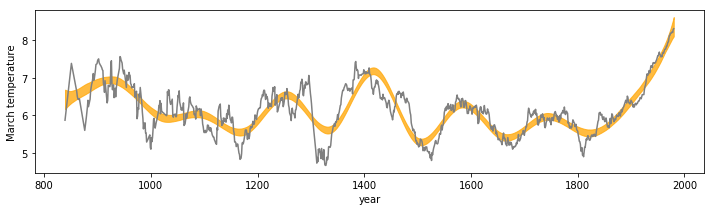

In [10]:
# Now, plot the data
plt.figure(figsize=(12,3))
plt.plot(df2.year, df2.temp, color='grey')
plt.fill_between(df2.year, mu_PI[0], mu_PI[1], alpha=0.75, color='orange')
plt.xlabel('year')
plt.ylabel('March temperature')
plt.show()

## Timings
After some [discussions on github](https://github.com/pymc-devs/resources/issues/28), it was suggested that I try running some timings on both the model above with the for loop, and on a version without the for loop.  This section is an effort to try those timings out.

In [11]:
# Define the two models, so they are both starting fresh.
with pm.Model() as mdl_w_forloop:
    a = pm.Normal('a', 6, 10)
    ws = [pm.Normal(f'w{i}', mu=0, sd=1) for i in range(B.shape[1])]
    mu = pm.Deterministic('mu', a + pm.math.dot(np.asarray(B), pm.math.stack(ws).T))
    sigma = pm.Exponential('sigma', 1)
    T = pm.Normal('T', mu, sigma, observed=df2.temp)
    
with pm.Model() as mdl_no_forloop:
    a = pm.Normal('a', 6, 10)
    ws = pm.Normal('w', mu=0, sd=1, shape=(B.shape[1], 1))
    mu = pm.Deterministic('mu', a + pm.math.dot(np.asarray(B), ws))
    sigma = pm.Exponential('sigma', 1)
    T = pm.Normal('T', mu, sigma, observed=df2.temp)

In [12]:
# And now, for the timings
pt1 = mdl_w_forloop.test_point
logp1 = mdl_w_forloop.logp
%timeit logp1(pt1)
pt2 = mdl_no_forloop.test_point
logp2 = mdl_no_forloop.logp
%timeit logp2(pt2)

497 µs ± 159 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
6.77 ms ± 1.04 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
